In [1]:
%run "../../shared/utilz_text_proc.ipynb"

# DNA Sequencing
**Dataset**
- Kaggle: chimp, dog and human dna

**Libraries**
- `biopython`

**Approach: NLP and k-mer counting**
- convert dna sequences as a 'language' << 1-step sliding window??
- b/c sequence vectors may not be of uniform length 
- 

## 1. Load Data
and check sample distribution @ balance

In [2]:
import os
### --- DATA SETS
DATA_DIR = '../../datasets/DNA'
DATA_FRAMEZ = {}

GENE_CLASS_FAMILY = [
    'G protein coupled receptors',
    'Tyrosine kinase',
    'Tyrosine phosphate',
    'Synthetase',
    'Synthase',
    'Ion channel',
    'Transcriptor factor'
]


for f in os.listdir( DATA_DIR ):
    k = f.split('_')[0]
    DATA_FRAMEZ[ k ] = pd.read_table( f'{DATA_DIR}/{f}')
    DATA_FRAMEZ[ k ]['species'] = k
#     print( f'--- {f}: {DATA_FRAMEZ[k].shape} ---\n{DATA_FRAMEZ[k].columns}')
#     DATA_FRAMEZ[k]['class'].value_counts(normalize=True)
#     print('\n')
full_db = pd.concat( [d for d in DATA_FRAMEZ.values()])

full_db.sample(5)

,sequence,class,species
2966,ATGAAGGGGCAGCAGAAAACAGCTGAAACGGAAGAGGGGACAGTGC...,6,human
1244,ATGGATATAGCAACAGGTCCCGAGTCGCTGGAGAGGTGCTTCCCTC...,6,chimp
258,ATGGAGCAGAAAATGAAATGTCCTCATTGTAAGGATCAGCTGGAGT...,1,human
3090,NACAACCACCTGGGCAACAACGATGGGGAGAACCTATCGGCGCCAT...,4,human
385,ATGGCCTGGGCTCTGAAGCTGCCTCTGGCCGACGAAGTGATTGAAT...,6,chimp


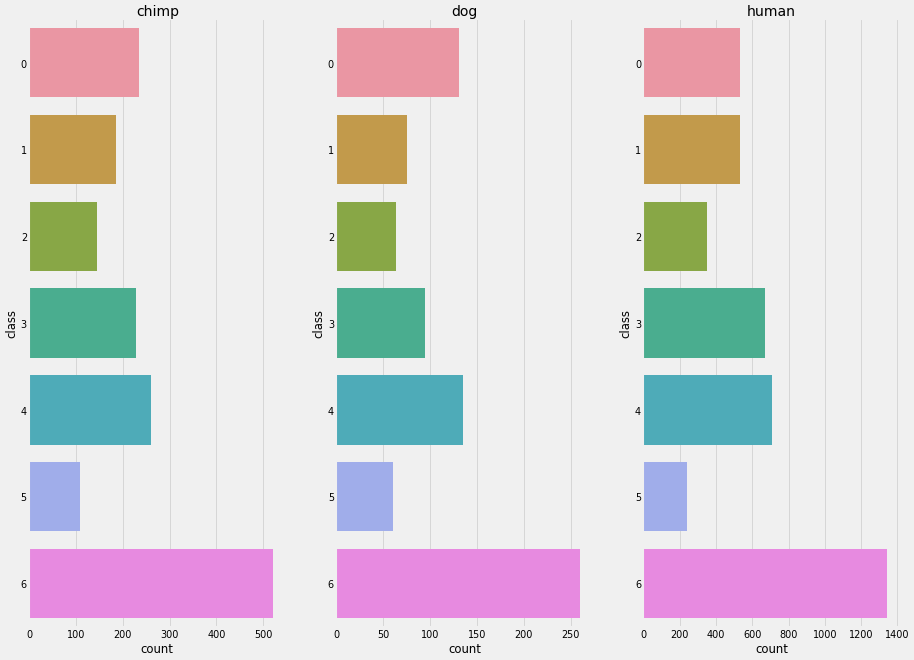

In [3]:
## Sample distribution
nr, nc = 1, 3
spz = full_db.species.unique()
for i, sp in enumerate(spz):
    plt.subplot(nr, nc, i+1)
    sns.countplot( y='class', data=full_db[ full_db.species == sp] )
    plt.title( sp ); 
plt.show();

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report

### Helperz
def gen_kmer_motifs(seq, k=6):
    return [ seq[x:x+k].lower() for x in range(len(seq) - k + 1)]

def grid_count_plotz(colz_list, labelz, nc=3):
    nl = len(colz_list) 
    nr = nl // nc
    if nl % nc != 0:
        nr += 1        
    for i, sp in enumerate(colz_list):
        plt.subplot(nr, nc, i+1)
        sns.countplot( x=sp )
        plt.ylabel('Class')
        plt.title( f'{labelz[i]}' ); 
    plt.show();

    
def get_performance_report(actualz, predz):
    cfmatrix = confusion_matrix(actualz, predz)
    creport = classification_report(actualz, predz)
    xtab = pd.crosstab( pd.Series(actualz, name='Actuals'), 
                       pd.Series(predz, name='Predictions'))
    a = (actualz == predz).mean()
    return a, cfmatrix, creport, xtab

def predict_by_species(t, df, bow_cvectorizer, model, nb_alpha=0.1):
    printHeadline(f'{t}', 'Setup and Train')
    ### 2. Train/Test Split
    perc_test, perc_val, rs = 0.2, 0.1, 43
    
    x_data, y_data = np.array(list(df['kmer_wordz'])) , np.array(list(df['class']))
    print( f'x_data:\t{x_data.shape} \ty_data:\t{y_data.shape}')
    x_data = bow_cvectorizer.transform(x_data)
    
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=perc_test, random_state=rs)
    
    # check is balanced
    grid_count_plotz( [y_train, y_test], ['training set', 'testing set'], nc=4)

    ### 3. Model train and prdict 
    model.fit(x_train, y_train)
    y_predz = model.predict( x_test )

    ### 5. Report 
    printHeadline(f'{t}', 'Model Performance Reports')

    a, b, c, d = get_performance_report(y_test, y_predz)

    print( f"Accuracy: { (a*100) }%") #'0.2f'%(a*100)
    print( f"\n1. Classification Report: \n{c}")
#     print( f"\n2. Confusion Matrix: \n{b}")
    print( f"\n3. Confusion Matrix Cross Tab: \n{d}")
    
    return a


In [5]:
### 1. Encode:
## 1.a. NLP gen wordz
full_db['kmer_wordz'] = full_db.apply( lambda x: gen_kmer_motifs(x['sequence']), axis=1)
full_db['kmer_wordz'] = full_db.apply(lambda x: ' '.join(x['kmer_wordz']), axis=1)
full_db.sample(2).T

## 1.b. bag of words vectorization <<< check index order not messed
bow_cvectorizer = CountVectorizer(ngram_range=(4,4))
bow_cvectorizer.fit( full_db['kmer_wordz'])

###2. Model spec
nb_model = MultinomialNB( alpha=0.1)

nb_model

,566,3556
sequence,ATGGAGCAGACTGAGAAACCAAAAGCATCTGCTGAGAAAGGACTCT...,ATGGCACATGTTTCTTCAGAAACTCAAGATGTTTCCCCCAAAGATG...
class,5,6
species,dog,human
kmer_wordz,atggag tggagc ggagca gagcag agcaga gcagac caga...,atggca tggcac ggcaca gcacat cacatg acatgt catg...


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(4, 4), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)


------ 1. CHIMP : Setup and Train ------
x_data:	(1682,) 	y_data:	(1682,)


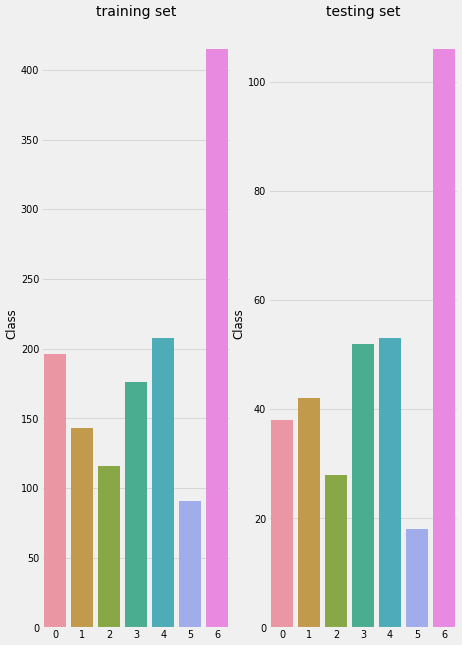


------ 2. CHIMP : Model Performance Reports ------
Accuracy: 91.0979228486647%

1. Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.76      0.87        38
           1       1.00      0.98      0.99        42
           2       1.00      0.89      0.94        28
           3       0.98      0.88      0.93        52
           4       0.98      0.85      0.91        53
           5       1.00      0.83      0.91        18
           6       0.79      1.00      0.88       106

    accuracy                           0.91       337
   macro avg       0.96      0.89      0.92       337
weighted avg       0.93      0.91      0.91       337


3. Confusion Matrix Cross Tab: 
Predictions   0   1   2   3   4   5    6
Actuals                                 
0            29   0   0   0   1   0    8
1             0  41   0   0   0   0    1
2             0   0  25   0   0   0    3
3             0   0   0  46   0   0    6
4             0 

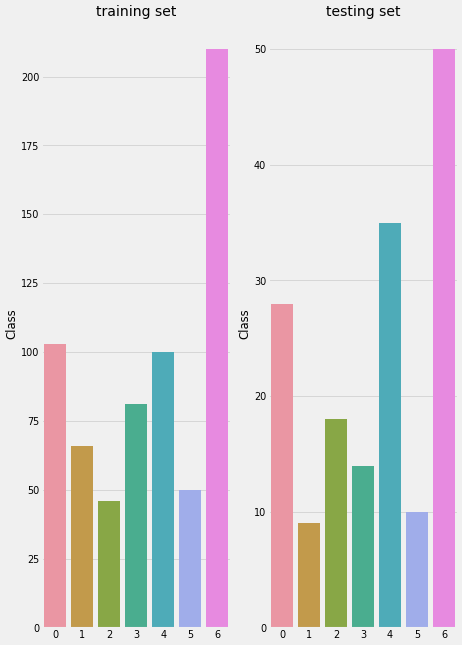


------ 4. DOG : Model Performance Reports ------
Accuracy: 67.6829268292683%

1. Classification Report: 
              precision    recall  f1-score   support

           0       0.56      0.82      0.67        28
           1       0.86      0.67      0.75         9
           2       1.00      0.44      0.62        18
           3       0.71      0.71      0.71        14
           4       0.78      0.51      0.62        35
           5       0.75      0.30      0.43        10
           6       0.64      0.86      0.74        50

    accuracy                           0.68       164
   macro avg       0.76      0.62      0.65       164
weighted avg       0.72      0.68      0.67       164


3. Confusion Matrix Cross Tab: 
Predictions   0  1  2   3   4  5   6
Actuals                             
0            23  0  0   0   1  0   4
1             0  6  0   1   0  0   2
2             5  1  8   0   0  0   4
3             0  0  0  10   0  0   4
4             8  0  0   2  18  0   7
5    

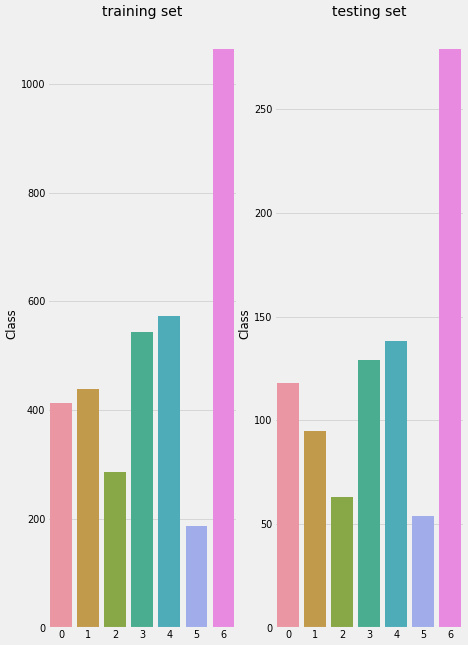


------ 6. HUMAN : Model Performance Reports ------
Accuracy: 98.40182648401826%

1. Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       118
           1       1.00      0.99      0.99        95
           2       1.00      1.00      1.00        63
           3       0.99      1.00      1.00       129
           4       0.99      0.95      0.97       138
           5       0.98      0.98      0.98        54
           6       0.97      0.99      0.98       279

    accuracy                           0.98       876
   macro avg       0.99      0.98      0.99       876
weighted avg       0.98      0.98      0.98       876


3. Confusion Matrix Cross Tab: 
Predictions    0   1   2    3    4   5    6
Actuals                                    
0            115   0   0    1    0   0    2
1              0  94   0    0    0   0    1
2              0   0  63    0    0   0    0
3              0   0   0  129    0   0   

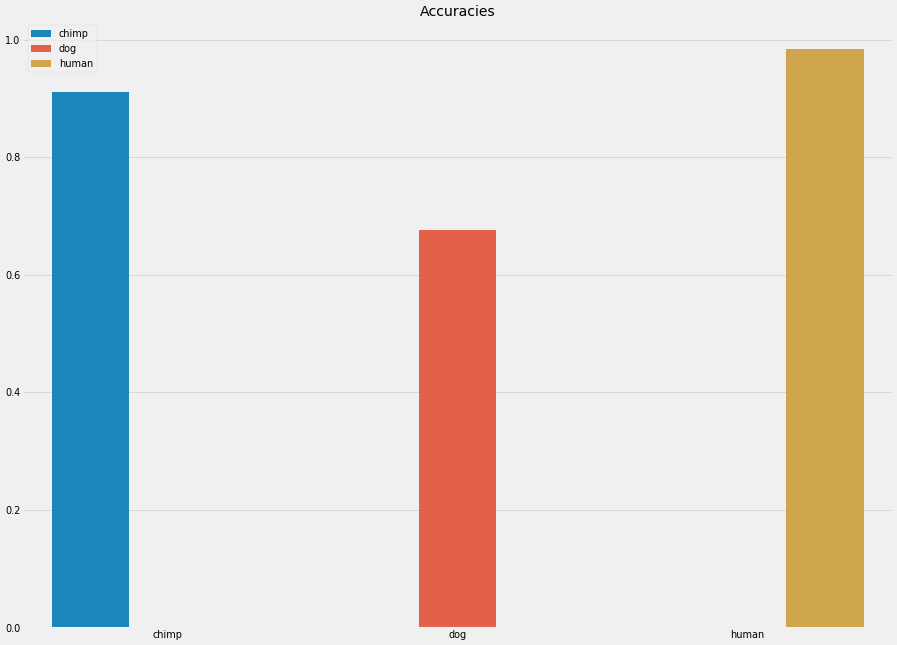

In [6]:
#### 3. run for each species
nr, nc = 1, 3
spz = full_db.species.unique()
accuraciez = []
for i, sp in enumerate(spz):
    accuraciez.append( 
        predict_by_species(sp, 
                           full_db[full_db['species'] == sp] ,
                           bow_cvectorizer,
                           nb_model) 
    )
    
# plt.plot(accuraciez);
sns.barplot(x=spz, y=accuraciez, hue=spz)
plt.title('Accuracies');

----

# Step by Step sandbox


-


-


## 2. Encoding
- k-mer motifs
- bag of words (`sklearn::CuntVectorizer`  

In [7]:
def gen_kmer_motifs(seq, k=6):
    return [ seq[x:x+k].lower() for x in range(len(seq) - k + 1)]

In [8]:
#gen_kmer_motifs('THE QUICK BROWN FOX')
## dO FOR HUMAN DATA FIRST
full_db['kmer_wordz'] = full_db.apply( lambda x: gen_kmer_motifs(x['sequence']), axis=1)
full_db.sample(2).T

,3935,4010
sequence,ATGGGAGGCCGCGTCTTTCTCGCATTCTGTGTCTGGCTGACTCTGC...,GAGCTGCTTAACAACCTGGGCAACTTCATCAACAGAGCTGGGATGT...
class,0,3
species,human,human
kmer_wordz,"[atggga, tgggag, gggagg, ggaggc, gaggcc, aggcc...","[gagctg, agctgc, gctgct, ctgctt, tgctta, gctta..."


In [9]:
#### --- Test with Humna DNA first
df = full_db[ full_db.species == 'human']

In [10]:
## define x_data and y_data
x_data, y_data = np.array([' '.join(x) for x in df['kmer_wordz']]), np.array(list(df['class']))

print( f'x_data:\t{x_data.shape} \ny_data:\t{y_data.shape}')
print( f'\tE.G::\t{x_data[0][:30]}...\t===>\t{y_data[0]}')


x_data:	(4380,) 
y_data:	(4380,)
	E.G::	atgccc tgcccc gcccca ccccaa cc...	===>	4


In [11]:
### bag of words vectorization
from sklearn.feature_extraction.text import CountVectorizer
bow_cvectorizer = CountVectorizer(ngram_range=(4,4))
bow_cvectorizer.fit( x_data)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(4, 4), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [12]:
## vectorize
xi_data = bow_cvectorizer.transform( x_data)
xi_data.shape
xi_data[0]

(4380, 232414)

<1x232414 sparse matrix of type '<class 'numpy.int64'>'
	with 197 stored elements in Compressed Sparse Row format>

## 3. Split train, test, validation

x_train:	(3504, 232414) 
x_test:	(876, 232414)


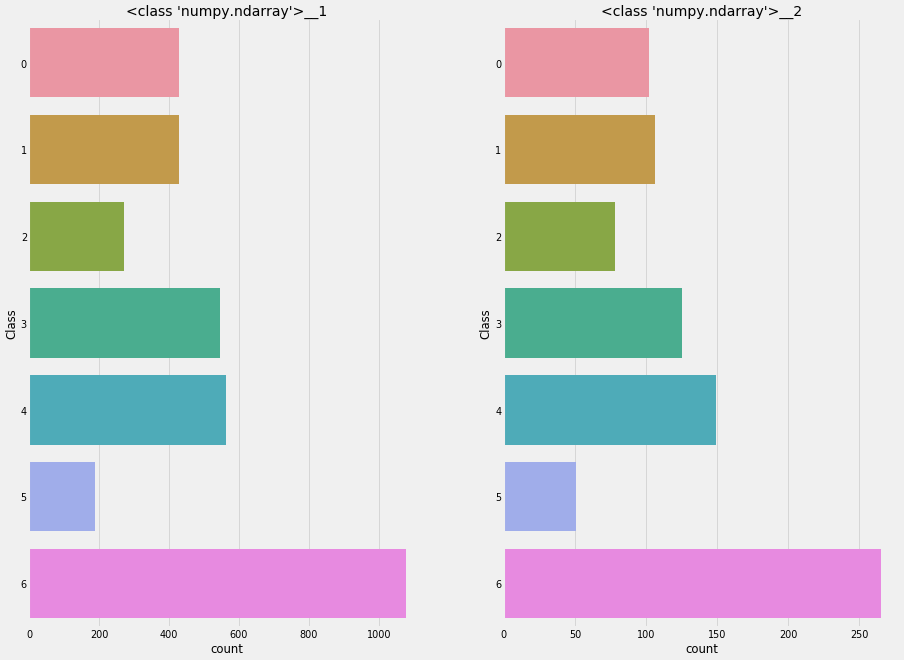

In [13]:
from sklearn.model_selection import train_test_split

perc_test, perc_val = 0.2, 0.1

x_train, x_test, y_train, y_test = train_test_split(
    xi_data, y_data, 
    test_size = perc_test, random_state=42
)

print( f'x_train:\t{x_train.shape} \nx_test:\t{x_test.shape}')

nr, nc = 1, 2 ## 3 if validate 
for i, sp in enumerate([y_train, y_test]):
    plt.subplot(nr, nc, i+1)
    sns.countplot( y=sp )
    plt.ylabel('Class')
    plt.title( f'{type(sp)}__{i+1}' ); 
plt.show();

## 4. Classify - NaiveBayes
- TODO: compare other modelz

In [14]:
### TODO: param tuning
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB( alpha=0.1)

model.fit(x_train, y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [15]:
### PREDICTIONS
y_predz = model.predict( x_test)
type(y_predz)

numpy.ndarray

## 5. Model Performance
- confusion matrix 
- 

In [16]:
from sklearn.metrics import confusion_matrix, classification_report

def get_performance_report(actualz, predz):
    cfmatrix = confusion_matrix(actualz, predz)
    creport = classification_report(actualz, predz)
    xtab = pd.crosstab( pd.Series(actualz, name='Actuals'), 
                       pd.Series(predz, name='Predictions'))
    a = (actualz == predz).mean()
    return a, cfmatrix, creport, xtab

printHeadline('', 'Model Performance Reports')



a, b, c, d = get_performance_report(y_test, y_predz)

print( f"Accuracy: { (a*100) }%") #'0.2f'%(a*100)
print( f"\n1. Classification Report: \n{c}")
print( f"\n2. Confusion Matrix: \n{b}")
print( f"\n3. Cross Tab: \n{d}")


------ 7.  : Model Performance Reports ------
Accuracy: 98.40182648401826%

1. Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       102
           1       1.00      0.98      0.99       106
           2       1.00      1.00      1.00        78
           3       0.99      0.99      0.99       125
           4       0.99      0.96      0.98       149
           5       1.00      1.00      1.00        51
           6       0.96      0.99      0.98       265

    accuracy                           0.98       876
   macro avg       0.99      0.99      0.99       876
weighted avg       0.98      0.98      0.98       876


2. Confusion Matrix: 
[[ 99   0   0   0   1   0   2]
 [  0 104   0   0   0   0   2]
 [  0   0  78   0   0   0   0]
 [  0   0   0 124   0   0   1]
 [  1   0   0   0 143   0   5]
 [  0   0   0   0   0  51   0]
 [  1   0   0   1   0   0 263]]

3. Cross Tab: 
Predictions   0    1   2    3    4   5    